In [1]:
from brix import Indicator, Handler
import OpenCity
import PreCompOsmNet
import statsmodels
from statsmodels.distributions.empirical_distribution import ECDF
import geopandas as gpd
import urllib
import json
import requests
import math
import osmnx
from shapely.geometry import Point, shape
import datetime
from scipy import spatial
import numpy as np

### TODO
- make a base class for proximity and density indicators to elimate repetition
- state only used for state.geom and subsetting thereof- really just need a shape file
- relevant column names should be in a settings file
- all US-specific functionality should be in OpenCity
- may not need the buffere area graph because its a subset of the ref area graph
- separate out functions for combining grid stats with zone stats- repeated in both indicators now
- only consider interactive cells in updates

In [2]:
table_name='epa_test'
geom_type='block_group'

In [3]:
def init_geogrid(table_name):
    """
    initialises the available types on the front-end to a default list from text file
    initialises the GEOGRIDDATA to all "None"
    """
    get_url='https://cityio.media.mit.edu/api/table/'+table_name
    post_url='https://cityio.media.mit.edu/api/table/update/'+table_name
    with urllib.request.urlopen(get_url+'/GEOGRID') as url:
        geogrid=json.loads(url.read().decode())  
    default_types=json.load(open('data/default_types.json'))
    geogrid['properties']['types']=default_types

    geogrid_data=[{
                    "color": [0,0,0,0],
                    "height": [0],
                    "id": i,
                    "interactive": "Web",
                    "name": "None",
                    "tui_id": None
                    } for i in range(len(geogrid['features']))]

    r = requests.post(post_url+'/GEOGRID', data = json.dumps(geogrid))
    print('Initialise GEOGRID: {}'.format(r))

    r = requests.post(post_url+'/GEOGRIDDATA', data = json.dumps(geogrid_data))
    print('Initialise GEOGRIDDATA: {}'.format(r))
    return geogrid['properties']
    
def identify_state(properties):
    # TODO: if table already existed, just load state from text file
    print('Downloading state outlines')
    state_outlines=gpd.read_file(
        'https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip')
    state_outlines=state_outlines.to_crs("EPSG:4326")
    table_lon, table_lat=properties['header']['longitude'], properties['header']['latitude']
    table_Point=Point(table_lon, table_lat)
    for ind, row in state_outlines.iterrows():
        if row['geometry'].contains(table_Point):
            return row['GEOID']
    return None

In [4]:
def aggregate_types_over_grid(geogrid_data, side_length, type_def):
    cell_area=side_length*side_length
    aggregated={}  
    for cell in geogrid_data:
        name=cell['name']
        type_info=type_def[name]
        height=cell['height']
        if isinstance(height, list):
            height=height[-1]
        if 'sqm_pperson' in type_info:
            sqm_pperson=type_info['sqm_pperson']
        else:
            sqm_pperson=50
        total_capacity=height*cell_area/sqm_pperson
        if name in aggregated:
            aggregated[name]+=total_capacity
        else:
            aggregated[name]=total_capacity
    return aggregated

def pop_one_cell(cell, side_length, type_def):
    name=cell['name']
    type_info=type_def[name]
    height=cell['height']
    cell_area=side_length*side_length
    if isinstance(height, list):
        height=height[-1]
    if 'sqm_pperson' in type_info:
        sqm_pperson=type_info['sqm_pperson']
    else:
        sqm_pperson=50
    total_capacity=height*cell_area/sqm_pperson
    if type_info['NAICS'] is None:
        emp=0
    else:
        emp=total_capacity*sum(type_info['NAICS'].values())
    if type_info['LBCS'] is None:
        res=0
    else:
        res=total_capacity*sum([type_info['LBCS'][code] for code in type_info['LBCS'] if code.startswith('1')])
    return res, emp
    
        

def aggregate_attributes_over_grid(geogrid_data, attribute, side_length, type_def, digits=None):
    # TODO: eliminate repetition with previous function
    cell_area=side_length*side_length
    aggregated={}
    for cell in geogrid_data:
        name=cell['name']
        type_info=type_def[name]
        if type_info[attribute] is not None:
            height=cell['height']
            if isinstance(height, list):
                height=height[-1]
            if 'sqm_pperson' in type_info:
                sqm_pperson=type_info['sqm_pperson']
            else:
                sqm_pperson=50
            total_capacity=height*cell_area/sqm_pperson
            for code in type_info[attribute]:
                if digits==None:
                    code_digits=code
                else:
                    code_digits=code[0:digits]
                add_capacity=total_capacity*type_info[attribute][code]
                if code_digits in aggregated:
                    aggregated[code_digits]+= add_capacity
                else:
                    aggregated[code_digits]= add_capacity
    return aggregated

In [5]:
def get_central_nodes(geodf, G):
    """ takes a geodf and returns a list of nodes closest to their centroids
    returns both the nearest nodes and the distance
    """
    geodf_projected=osmnx.projection.project_gdf(geodf)
    projected_centroids=geodf_projected['geometry'].centroid.values
    projected_centroids_lst=[[c.x, c.y] for c in projected_centroids]
    G_proj=osmnx.projection.project_graph(G, geodf_projected.crs)
    G_proj_coordinates={node: [G_proj.nodes[node]['x'], G_proj.nodes[node]['y']] for node in G_proj.nodes}
    node_order=[node for node in G_proj_coordinates]
    nodes_kdtree=spatial.KDTree([G_proj_coordinates[node] for node in node_order])
    dist, ind_nearest=nodes_kdtree.query(projected_centroids_lst)
    nearest_nodes=[node_order[ind] for ind in ind_nearest]
    return nearest_nodes, dist

In [6]:
class Proximity_Indicator(Indicator):
    def load(self, state, table_name, buffer=1200):
        self.zone_to_node_tolerance=500
        self.grid_to_node_tolerance=100
        self.table_name=table_name
        self.buffer=buffer
        self.state=state
        self.get_geogrid()
        self.get_overlap_geoids()
#         self.G=self.get_network_around_geom_buffered(self.geogrid)
        self.get_graph_reference_area()
    
        print('Getting central nodes')
        zones_nearest_nodes, zones_nearest_dist= get_central_nodes(self.state.geom, self.ref_G)
        self.state.geom['central_node']=zones_nearest_nodes
        self.state.geom['nearest_dist']=zones_nearest_dist
        
        grid_nearest_nodes, grid_nearest_dist= get_central_nodes(self.geogrid, self.ref_G)
        self.geogrid['central_node']=grid_nearest_nodes
        self.geogrid['nearest_dist']=grid_nearest_dist
#         self.state.geom['central_node']=osmnx.get_nearest_nodes(
#             self.ref_G, self.state.geom['x_centroid'], self.state.geom['y_centroid'], method='balltree')
#         self.geogrid['central_node']=osmnx.get_nearest_nodes(
#             self.ref_G, self.geogrid['x_centroid'], self.geogrid['y_centroid'], method='balltree')
        self.calculate_baseline_scores()
        self.get_reachable_geoms_all_interactive()
        
        
    def get_geogrid(self):
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            self.geogrid=gpd.read_file(url.read().decode())
        centroids=self.geogrid['geometry'].centroid
        self.geogrid['x_centroid']=[c.x for c in centroids]
        self.geogrid['y_centroid']=[c.y for c in centroids]
                       
    def get_overlap_geoids(self):
        """
        find the geoids of the baseline zones which overlap with hthe geogrid
        
        """
        self.state.geom['copy_GEOID']=self.state.geom.index
        grid_intersect_zones=gpd.overlay(self.geogrid, self.state.geom, 'intersection')
        self.overlapping_geoids=grid_intersect_zones['copy_GEOID'].unique()
            
            
    def make_ego_graph_around_geometry(self, zone, tolerance):
        """
        For geometries within the buffered geogrid only.
        Returns the graph within a walkable distance of the centre of the zone
        """
        if zone['nearest_dist']<tolerance:
            sub_graph = osmnx.graph.nx.ego_graph(self.ref_G, zone['central_node'], radius=1200, distance='length')
        else:
            sub_graph = osmnx.graph.nx.Graph()
        return sub_graph
    
    def get_graph_reference_area(self):
        self.state.subset_geom_by_distance(centre_x_y=[self.geogrid.x_centroid.mean(), self.geogrid.y_centroid.mean()], 
                                           radius=2500, name='reference')
        reference_zones=self.state.return_geometry(subset_name='reference')
        print('Downloading graph for reference area')
        reference_zone_graph=self.get_network_around_geom_buffered(reference_zones)
        self.ref_G=reference_zone_graph
        
    def calculate_baseline_scores(self):
        # TODO: should use the get_reachable_geoms function?
        print('Calculating baseline scores')
        self.base_scores={'walkable_{}'.format(x): [] for x in [
            'employment', 'housing', 'healthcare', 'hospitality', 'shopping']}
        self.score_ecdfs={}
        for ind, row in self.state.geom.loc[self.state.geom['reference']].iterrows():
            # TODO: normalise each score by density at source?
            sub_graph=self.make_ego_graph_around_geometry(row, tolerance=self.zone_to_node_tolerance)
            sub_graph_nodes=sub_graph.nodes(data=False)
            reachable_zones= list(self.state.geom.loc[
                ((self.state.geom['central_node'].isin(list(sub_graph_nodes)))&
                 (self.state.geom['nearest_dist']<self.zone_to_node_tolerance))
                ].index.values)
            stats_to_aggregate=['total_pop_rac', 'total_employ_wac']+[
                col for col in self.state.geom.columns if (('naics' in col) or ('income' in col))]
            reachable_area_attributes=self.state.geom.loc[reachable_zones][stats_to_aggregate].sum()
            self.base_scores['walkable_employment'].append(reachable_area_attributes['total_employ_wac'])
            self.base_scores['walkable_housing'].append(reachable_area_attributes['total_pop_rac'])
            self.base_scores['walkable_healthcare'].append(reachable_area_attributes['emp_naics_62'])
            self.base_scores['walkable_hospitality'].append(reachable_area_attributes['emp_naics_72'])
            self.base_scores['walkable_shopping'].append(reachable_area_attributes['emp_naics_44-45'])
        for score in self.base_scores:
            base_scores_no_nan=[x for x in self.base_scores[score] if x==x]
            self.score_ecdfs[score]=ECDF(base_scores_no_nan)
            
    def get_reachable_geoms(self, zone, tolerance):
        """
        find all grid cells and all zones reachable from a geometry
        """
        sub_graph=self.make_ego_graph_around_geometry(zone, tolerance)
        sub_graph_nodes=sub_graph.nodes(data=False)
        reachable_zones= list(self.state.geom.loc[
                ((self.state.geom['central_node'].isin(list(sub_graph_nodes)))&
                 (self.state.geom['nearest_dist']<self.zone_to_node_tolerance))
                ].index.values)
        reachable_grid_cells=list(self.geogrid.loc[
                ((self.geogrid['central_node'].isin(list(sub_graph_nodes)))&
                 (self.geogrid['nearest_dist']<self.grid_to_node_tolerance))
                ].index.values)
        return {'zones': reachable_zones, 'cells': reachable_grid_cells}
    
    def get_reachable_geoms_all_interactive(self):
        """
        For every grid cell and every zone which intersects the grid:
        find the reachable zones and reachable grid cells
        """
        self.grid_to_reachable, self.zone_to_reachable={}, {}
        for ind, row in self.geogrid.iterrows():
            self.grid_to_reachable[ind]=self.get_reachable_geoms(row, self.grid_to_node_tolerance)
        for ind, row in self.state.geom.loc[self.overlapping_geoids].iterrows():
            self.zone_to_reachable[ind]=self.get_reachable_geoms(row, self.zone_to_node_tolerance)
            
    def aggregate_reachable_attributes_one_source(self, zones, cells, geogrid_data=None):
        stats_to_aggregate=['total_pop_rac', 'total_employ_wac']+[
                col for col in self.state.geom.columns if (('naics' in col) or ('income' in col))]
        reachable_area_stats=dict(self.state.geom.loc[zones, stats_to_aggregate].sum())
        if geogrid_data is not None:
            geogrid_data_reachable=[geogrid_data[c] for c in cells]
            side_length=self.get_table_properties()['cellSize']
            type_def=geogrid_data.get_type_info()
            agg_types=aggregate_types_over_grid(geogrid_data_reachable, side_length=side_length, type_def=type_def)
            agg_naics=aggregate_attributes_over_grid(geogrid_data_reachable, 'NAICS', side_length=side_length, type_def=type_def, digits=2)
            agg_lbcs=aggregate_attributes_over_grid(geogrid_data_reachable, 'LBCS', side_length=side_length, type_def=type_def, digits=1)
            
            # update total residential and total employment
            add_emp=sum(agg_naics.values())
            if '1' in agg_lbcs:
                add_res=agg_lbcs['1']
            else:
                add_res=0    
            reachable_area_stats['total_pop_rac']+=add_res
            reachable_area_stats['total_employ_wac']+=add_emp
            
            # update employment for each NAICS code
            for col in reachable_area_stats:
                if 'naics' in col:
                    col_naics_codes=col.split('naics_')[1].split('-')
                    for code in col_naics_codes:
                        if code in agg_naics:
                            reachable_area_stats[col]+=agg_naics[code]                             
            # update residential types
            if 'Residential Low Income' in agg_types:
                reachable_area_stats['res_income_u1250_rac']+=agg_types['Residential Low Income']
            if 'Residential Med Income' in agg_types:
                reachable_area_stats['res_income_1251-3333_rac']+=agg_types['Residential Med Income']
            if 'Residential High Income' in agg_types:
                reachable_area_stats['res_income_3333+_rac']+=agg_types['Residential High Income'] 
        return reachable_area_stats
                
    def aggregate_reachable_attributes_all_sources(self, geogrid_data=None):
        zone_reachable_area_stats, grid_reachable_area_stats=[], []
        for ind, row in self.state.geom.loc[self.overlapping_geoids].iterrows():
            reachable_area_stats=self.aggregate_reachable_attributes_one_source(
                self.zone_to_reachable[ind]['zones'], self.zone_to_reachable[ind]['cells'], geogrid_data)
            reachable_area_stats['source_pop']=row['total_pop_rac']
            reachable_area_stats['source_emp']=row['total_employ_wac']
            reachable_area_stats['GEOID']=ind
            zone_reachable_area_stats.append(reachable_area_stats)
        if geogrid_data is not None:
            side_length=self.get_table_properties()['cellSize']
            type_def=geogrid_data.get_type_info()
            for i_c, cell in enumerate(geogrid_data):
                reachable_area_stats=self.aggregate_reachable_attributes_one_source(
                    self.grid_to_reachable[i_c]['zones'], self.grid_to_reachable[i_c]['cells'], geogrid_data)
                res, emp=pop_one_cell(cell, side_length, type_def)
                reachable_area_stats['source_pop']=res
                reachable_area_stats['source_emp']=emp
                reachable_area_stats['id']=i_c
                grid_reachable_area_stats.append(reachable_area_stats)
        return zone_reachable_area_stats, grid_reachable_area_stats
    
    def compute_heatmaps(self, grid_reachable_area_stats):
        max_scores={score: max(self.base_scores[score]) for score in self.base_scores}
        features=[]
        heatmap={'type': 'FeatureCollection',
                 'properties': ['housing', 'employment', 'healthcare', 'hospitality', 'shopping']}
        x_centroid_list, y_centroid_list=self.geogrid['x_centroid'], self.geogrid['y_centroid']
        for i_c, cell_stats in enumerate(grid_reachable_area_stats):
            features.append({
              "type": "Feature",
              "properties": [(cell_stats['total_pop_rac']/max_scores['walkable_housing'])**2, 
                             (cell_stats['total_employ_wac']/max_scores['walkable_employment'])**2,
                             (cell_stats['emp_naics_62']/max_scores['walkable_healthcare'])**2, 
                             (cell_stats['emp_naics_72']/max_scores['walkable_hospitality'])**2, 
                             (cell_stats['emp_naics_44-45']/max_scores['walkable_shopping'])**2],
              "geometry": {
                "type": "Point",
                "coordinates": [
                  x_centroid_list[i_c],
                  y_centroid_list[i_c]
                ]
              }
            })
        heatmap['features']=features
        return heatmap
                 
    def calculate_indicators(self, site_stats):
        raw_ind={}
        sum_all_source_pop=sum([s['source_pop'] for s in site_stats])
        sum_all_source_emp=sum([s['source_emp'] for s in site_stats])
        raw_ind['walkable_housing']=sum([s['source_emp']*s['total_pop_rac'] for s in site_stats])/sum_all_source_emp
        raw_ind['walkable_employment']=sum([s['source_pop']*s['total_employ_wac'] for s in site_stats])/sum_all_source_pop
        raw_ind['walkable_healthcare']=sum([s['source_pop']*s['emp_naics_62'] for s in site_stats])/sum_all_source_pop
        raw_ind['walkable_hospitality']=sum([s['source_pop']*s['emp_naics_72'] for s in site_stats])/sum_all_source_pop
        raw_ind['walkable_shopping']=sum([s['source_pop']*s['emp_naics_44-45'] for s in site_stats])/sum_all_source_pop
        
        norm_ind={}
        for ind_name in raw_ind:
            norm_ind[ind_name]=self.score_ecdfs[ind_name](raw_ind[ind_name])       
        return {'raw': raw_ind, 'norm': norm_ind}
                  
    def return_indicator(self, geogrid_data):
        start_ind_calc=datetime.datetime.now()
        zone_site_stats, grid_site_stats=self.aggregate_reachable_attributes_all_sources(geogrid_data)
        new_ind=self.calculate_indicators(zone_site_stats + grid_site_stats)
        
        base_zone_site_stats, base_grid_site_stats=self.aggregate_reachable_attributes_all_sources()
        base_ind=self.calculate_indicators(base_zone_site_stats)
        
        outputs=[]
        for ind_name in new_ind['raw']:
            outputs.append({'name': ind_name.replace('_', ' ').title(),
                           'raw_value': new_ind['raw'][ind_name],
                           'value': new_ind['norm'][ind_name],
                           'ref_value': base_ind['norm'][ind_name]})
        end_ind_calc=datetime.datetime.now()
        
        heatmap=self.compute_heatmaps(grid_site_stats)
        post_url='https://cityio.media.mit.edu/api/table/update/'+self.table_name       
        r = requests.post(post_url+'/access', data = json.dumps(heatmap))
        print('Post heatmap: {}'.format(r))
        end_hm_calc=datetime.datetime.now()
        
        print('Prox Ind: {}'.format(end_ind_calc-start_ind_calc))
        print('Prox HM: {}'.format(end_hm_calc-end_ind_calc))
        
        return outputs
      
    def get_network_around_geom_buffered(self, geom):
        """
        Creates a buffer around the geometry and downloads the graph for this area
        """
        geom_projected=osmnx.projection.project_gdf(geom)
        geom_projected_buffered=geom_projected.unary_union.buffer(self.buffer)

        geom_projected_buffered_gdf=gpd.GeoDataFrame(geometry=[geom_projected_buffered], crs=geom_projected.crs)
        geom_wgs_buffered_gdf=geom_projected_buffered_gdf.to_crs(geom.crs) 
        
        return osmnx.graph.graph_from_polygon(geom_wgs_buffered_gdf.iloc[0]['geometry'], network_type='walk')

In [7]:
# H=Handler(table_name=table_name)
# print(H.table_name)

# p=Proximity_Indicator()
# p.link_table(table_name=table_name)

# H.add_indicator(p)

# p.load(state=st, table_name=table_name) 

# H.listen()

In [8]:
class Density_Indicator(Indicator):
    def load(self, state, table_name_x):
        self.state=state
        self.table_name_x=table_name_x
#         self.requires_geometry=True
        self.grid_cell_area=None
#         self.init_geogrid()
        if 'ALAND' in self.state.geom.columns:
            self.state.geom['area']=self.state.geom['ALAND']
        else:
            self.state.geom['area']=self.state.geom['ALAND10']
        self.get_overlap_geoids()
        self.compute_base_score_distribution()
                
    def compute_base_score_distribution(self):
        """
        computes ECDFs of the indicators across the baseline zones
        the ECDFs are later used to nromalise indicators by finding the percentile rank of the updated site wrt
        the baseline zones
        """
        self.score_ecdfs={}
        self.base_scores={}
        self.base_scores['res_density']=self.state.geom.apply(lambda row: self.res_density(row), axis=1)
        self.base_scores['emp_density']=self.state.geom.apply(lambda row: self.emp_density(row), axis=1)
        self.base_scores['live_work_score']=self.state.geom.apply(
            lambda row: self.get_live_work_score(row), axis=1)
        
        # Diversity
        industry_columns=[col for col in self.state.geom.columns if 'emp_naics' in col]
        res_income_columns=[col for col in self.state.geom.columns if 'res_income' in col]
        
        self.base_scores['industry_diversity']=self.state.geom.apply(
            lambda row: self.get_diversity(row, species_columns=industry_columns), axis=1)
        self.base_scores['income_diversity']=self.state.geom.apply(
            lambda row: self.get_diversity(row, species_columns=res_income_columns), axis=1)
        
        for score in self.base_scores:
#             plt.figure()
#             plt.hist(self.base_scores[score])
#             plt.title(score)
            base_scores_no_nan=[x for x in self.base_scores[score] if x==x]
            self.score_ecdfs[score]=ECDF(base_scores_no_nan)
            
    def get_overlap_geoids(self):
        """
        find the geoids of the baseline zones which overlap with hthe geogrid
        
        """
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name_x
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            geogrid=gpd.read_file(url.read().decode())

        self.state.geom['copy_GEOID']=self.state.geom.index
        grid_intersect_zones=gpd.overlay(geogrid, self.state.geom, 'intersection')
        self.overlapping_geoids=grid_intersect_zones['copy_GEOID'].unique()
        
    def combine_site_attributes(self, geogrid_data=None):
        """
        takes the attributes of the geogrid_data (new programming) and 
        the zones which overlap with the geogrid and (pre-existing programming)
        aggregates them together to get the updated site stats
        """
        stats_to_aggregate=['total_pop_rac', 'total_employ_wac', 'area']+[
            col for col in self.state.geom.columns if (('naics' in col) or ('income' in col))]
        temp_site_stats=dict(self.state.geom.loc[self.overlapping_geoids, 
                                                 stats_to_aggregate].sum())
        if geogrid_data is not None:
            side_length=self.get_table_properties()['cellSize']
            type_def=geogrid_data.get_type_info()
            agg_types=aggregate_types_over_grid(geogrid_data, side_length=side_length, type_def=type_def)
            agg_naics=aggregate_attributes_over_grid(geogrid_data, 'NAICS', side_length=side_length, type_def=type_def, digits=2)
            agg_lbcs=aggregate_attributes_over_grid(geogrid_data, 'LBCS', side_length=side_length, type_def=type_def, digits=1)
            
            # update total residential and total employment
            add_emp=sum(agg_naics.values())
            if '1' in agg_lbcs:
                add_res=agg_lbcs['1']
            else:
                add_res=0    
            temp_site_stats['total_pop_rac']+=add_res
            temp_site_stats['total_employ_wac']+=add_emp
            
            # update employment for each NAICS code
            for col in temp_site_stats:
                if 'naics' in col:
                    col_naics_codes=col.split('naics_')[1].split('-')
                    for code in col_naics_codes:
                        if code in agg_naics:
                            temp_site_stats[col]+=agg_naics[code]  
                            
            # update residential types
            if 'Residential Low Income' in agg_types:
                temp_site_stats['res_income_u1250_rac']+=agg_types['Residential Low Income']
            if 'Residential Med Income' in agg_types:
                temp_site_stats['res_income_1251-3333_rac']+=agg_types['Residential Med Income']
            if 'Residential High Income' in agg_types:
                temp_site_stats['res_income_3333+_rac']+=agg_types['Residential High Income']          
        return temp_site_stats

    
    def calculate_indicators(self, site_stats):
        raw_ind={}
        raw_ind['res_density']=self.res_density(site_stats)
        raw_ind['emp_density']=self.emp_density(site_stats)
        raw_ind['live_work_score']=self.get_live_work_score(site_stats)
        
        industry_columns=[col for col in self.state.geom.columns if 'emp_naics' in col]
        res_income_columns=[col for col in self.state.geom.columns if 'res_income' in col]
        
        raw_ind['industry_diversity']=self.get_diversity(site_stats, species_columns=industry_columns)
        raw_ind['income_diversity']=self.get_diversity(site_stats, species_columns=res_income_columns)
               
        norm_ind={}
        for ind_name in raw_ind:
            norm_ind[ind_name]=self.score_ecdfs[ind_name](raw_ind[ind_name])       
        return {'raw': raw_ind, 'norm': norm_ind}
                  
    def return_indicator(self, geogrid_data):
        start_ind_calc=datetime.datetime.now()
        new_site_stats=self.combine_site_attributes(geogrid_data=geogrid_data)
        new_ind=self.calculate_indicators(new_site_stats)
        
        base_site_stats=self.combine_site_attributes(geogrid_data=None)
        base_ind=self.calculate_indicators(base_site_stats)
        
        outputs=[]
        for ind_name in new_ind['raw']:
            outputs.append({'name': ind_name.replace('_', ' ').title(),
                           'raw_value': new_ind['raw'][ind_name],
                           'value': new_ind['norm'][ind_name],
                           'ref_value': base_ind['norm'][ind_name]})
        end_ind_calc=datetime.datetime.now()
        print('Dens Ind: {}'.format(end_ind_calc-start_ind_calc))
#         print(outputs)
        return outputs
    
    @staticmethod
    def res_density(obj):
        """
        input can be a row if the baseline geodataframe
        or a dict representing a dynamic site
        """
        if obj['area']>0:
            return obj['total_pop_rac']/obj['area']
        return 0
    
    @staticmethod
    def emp_density(obj):
        """
        input can be a row if the baseline geodataframe
        or a dict representing a dynamic site
        """
        if obj['area']>0:
            return obj['total_employ_wac']/obj['area'] 
        return 0
    
    @staticmethod
    def get_live_work_score(obj):
        if obj['total_pop_rac'] > obj['total_employ_wac']:
            return obj['total_employ_wac']/obj['total_pop_rac']
        else:
            return obj['total_pop_rac']/obj['total_employ_wac']
     
    @staticmethod
    def get_diversity(obj, species_columns):
        species_counts=[obj[col] for col in species_columns]
        diversity=0
        pop_size=sum(species_counts)
        if ((len(species_counts)>1) and (pop_size>0)):        
            for count in species_counts:
                pj=count/pop_size
                if not pj==0:
                    diversity+= -pj*math.log(pj)
            equitability=diversity/math.log(len(species_counts))
            return equitability
        else:
            return float('nan')

In [9]:
def mode_choice_model(all_trips_df):
    all_trips_df['mode']='walk'
    return all_trips_df

class Mobility_indicator(Indicator):
    def load(self, state, table_name):
        self.state=state
        self.table_name=table_name
        if not hasattr(self.state, 'od'):
            self.state.get_lodes_data(include=['od'])
        self.get_geogrid()
        self.get_overlap_geoids()
        self.state.geom['sim_area']=self.state.geom.index.isin(self.overlapping_geoids)
        self.state.subset_geom_by_distance([self.geogrid['x_centroid'].mean(), self.geogrid['y_centroid'].mean()],
                                           10000, 'model_area')
        simpop_df=state.lodes_to_pop_table(
            model_subset_name='model_area', sim_subset_name='sim_area')
        self.base_simpop_df=simpop_df.copy()
        self.build_mobsys() 
        print('Init simulation')
        model_zones=self.state.return_geometry('model_area')
        self.sim=OpenCity.Simulation(simpop_df, self.mob_sys, model_zones)
        self.sim.set_choice_models(mode_chooser=mode_choice_model)

        
    def get_geogrid(self):
        # repetition with proximity indicator
        get_url='https://cityio.media.mit.edu/api/table/'+self.table_name
        with urllib.request.urlopen(get_url+'/GEOGRID') as url:
            self.geogrid=gpd.read_file(url.read().decode())
        centroids=self.geogrid['geometry'].centroid
        self.geogrid['x_centroid']=[c.x for c in centroids]
        self.geogrid['y_centroid']=[c.y for c in centroids]
                       
    def get_overlap_geoids(self):
        # repetition with proximity indicator
        """
        find the geoids of the baseline zones which overlap with hthe geogrid
        
        """
        self.state.geom['copy_GEOID']=self.state.geom.index
        grid_intersect_zones=gpd.overlay(self.geogrid, self.state.geom, 'intersection')
        self.overlapping_geoids=grid_intersect_zones['copy_GEOID'].unique()
        
    def build_mobsys(self):
        print('Building Mobility System')
        print('\t getting graph')
        G_walk = osmnx.graph.graph_from_polygon(self.state.geom.loc[self.state.geom['sim_area']].unary_union, network_type='walk')
        for edge in list(G_walk.edges):
            G_walk.edges[edge]['speed_kph']=4.8
        G_walk=PreCompOsmNet.simplify_network(G_walk)
        G_walk=osmnx.add_edge_travel_times(G_walk)
        print('\t precomputing paths')
        fw_pred_walk=PreCompOsmNet.pre_compute_paths(G_walk)
        pre_comp_walk=PreCompOsmNet.PreCompOSMNet(G_walk, fw_pred_walk)
        networks={'walk': pre_comp_walk}
        
        walk_dict={
            'target_network_id': 'walk',
            'travel_time_metric': 'travel_time'}
        modes={'walk': OpenCity.Mode(walk_dict)}

        self.mob_sys=OpenCity.MobilitySystem(modes=modes,
                              networks=networks)
        
        
    def routes_to_deckgl_trip(self, route_table):
#         attr_map={'earnings': 
#               {0: {'name': 'Low Income', 'color': '#1b9e77'},
#                1: {'name': 'Med Income', 'color': '#d95f02'},
#                2: {'name': 'High Income', 'color': '#7570b3'}}}

        attr_map={"mode": {
                    "0": {
                    "color": "#e41a1d",
                    "name": "Drive"
                    },
                    "1": {
                    "color": "#377eb8",
                    "name": "Cycle"
                    },
                    "2": {
                    "color": "#4daf4a",
                    "name": "Walk"
                    },
                    "3": {
                    "color": "#ffff33",
                    "name": "Public Transport"
                    }}}
#         earnings_to_ind={'u1250': 0, '1250to3333': 1, '3333plus': 2}
        trips=[]
        for ind, row in route_table.iterrows():
            coords=row['attributes']['coordinates']
            if len(coords)>1:
                cum_time=np.cumsum(row['attributes']['travel_time'])
                start_time=int(row['start_time'])
                timestamps=[int(start_time)] + [int(start_time)+ int(ct) for ct in cum_time]
                this_trip={'path': coords, 'timestamps': timestamps}
#                 for attr in ['earnings']:
#                     this_trip[attr]=row[attr]
#                 this_trip['earnings']=earnings_to_ind[row['earnings']]
                this_trip['mode']="0"
                trips.append(this_trip)
        return {'attr': attr_map, 'trips': trips}
        
    def simulate(self, simpop_df):
        simpop_df=self.sim.create_activity_schedules(simpop_df)
        all_trips_df=self.sim.create_trip_table(simpop_df)
        route_table=self.sim.get_routes_table(all_trips_df)
        deckgl_trips=self.routes_to_deckgl_trip(route_table)
        return deckgl_trips
    
    def post_trips(self, deckgl_trips):
        post_url='https://cityio.media.mit.edu/api/table/update/'+self.table_name
        r = requests.post(post_url+'/ABM2', data = json.dumps(deckgl_trips))
        print('Post ABM: {}'.format(r))

In [10]:
# st=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
# st.get_geometry()
# st.remove_non_urban_zones()
# st.get_lodes_data( include=['wac', 'rac', 'od'])
# st.add_lodes_cols_to_shape()

In [11]:
# H=Handler(table_name=table_name)
# print(H.table_name)

# m=Mobility_indicator()
# m.link_table(table_name=table_name)

# H.add_indicator(m)

# m.load(state=st, table_name=table_name) 

# # H.listen()

In [12]:
# trips=m.simulate(m.base_simpop_df)
# import random
# if len(trips['trips'])>2000:
#     trips['trips']=random.choices(trips['trips'], k=2000)
# m.post_trips(trips)

# Run the CityScope Model

In [13]:
# properties=init_geogrid('epa_test')
# state_fips=identify_state(properties)

# ca=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
# ca.get_geometry()
# ca.remove_non_urban_zones()
# ca.get_lodes_data( include=['wac', 'rac'])
# ca.add_lodes_cols_to_shape()


In [14]:
# properties=init_geogrid('dungeonb')
# state_fips=identify_state(properties)

# ma=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
# ma.get_geometry()
# ma.remove_non_urban_zones()
# ma.get_lodes_data( include=['wac', 'rac'])
# ma.add_lodes_cols_to_shape()

Initialise GEOGRID: <Response [200]>
Initialise GEOGRIDDATA: <Response [200]>
Getting geometry (block_group) for state: California


/Volumes/GoogleDrive/My Drive/OpenCity/OpenCity.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids=self.geom['geometry'].centroid


Subsetting by urbanized areas
Getting WAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting WAC data
Getting RAC data from https://lehd.ces.census.gov/data/lodes/LODES7/
	 Formatting RAC data


<AxesSubplot:>

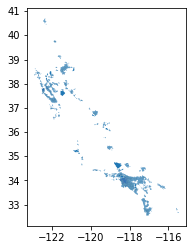

In [15]:
properties=init_geogrid(table_name)
state_fips=identify_state(properties)

st=OpenCity.US_State(state_fips, year=2018, geom_type=geom_type)
st.get_geometry()
st.remove_non_urban_zones()
st.get_lodes_data( include=['wac', 'rac'])
st.add_lodes_cols_to_shape()
st.geom.plot()

In [16]:
H=Handler(table_name=table_name)
print(H.table_name)

d=Density_Indicator()
d.link_table(table_name=table_name)

p=Proximity_Indicator()
p.link_table(table_name=table_name)

H.add_indicator(d)
H.add_indicator(p)

d.load(state=st, table_name_x=table_name)
p.load(state=st, table_name=table_name) 

epa_test


/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:337: UserWarning: Indicator 0001 has a table linked to it. Remember you do not need to link_table when using the Handler class
  warn(f'Indicator {indicatorName} has a table linked to it. Remember you do not need to link_table when using the Handler class')
/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:354: UserWarning: Indicator not working: 0001
  warn('Indicator not working: '+indicatorName)
/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:337: UserWarning: Indicator 0002 has a table linked to it. Remember you do not need to link_table when using the Handler class
  warn(f'Indicator {indicatorName} has a table linked to it. Remember you do not need to link_table when using the Handler class')
/Users/doorleyr/anaconda/envs/shapely/lib/python3.8/site-packages/brix/classes.py:354: UserWarning: Indicator not working: 0002
  warn('Indicato

	 Subsetting zones by distance
Getting central nodes
Calculating baseline scores


In [17]:
H.listen()

Dens Ind: 0:00:00.745848
Post heatmap: <Response [200]>
Prox Ind: 0:00:01.928428
Prox HM: 0:00:00.674385
Dens Ind: 0:00:00.081107
Post heatmap: <Response [200]>
Prox Ind: 0:00:02.156836
Prox HM: 0:00:00.636148
Dens Ind: 0:00:00.257637
Post heatmap: <Response [200]>
Prox Ind: 0:00:05.615217
Prox HM: 0:00:00.872934
Dens Ind: 0:00:00.027955
Post heatmap: <Response [200]>
Prox Ind: 0:00:04.307128
Prox HM: 0:00:00.797839
Dens Ind: 0:00:00.105574
Post heatmap: <Response [200]>
Prox Ind: 0:00:03.559448
Prox HM: 0:00:01.032160
Dens Ind: 0:00:00.189632
Post heatmap: <Response [200]>
Prox Ind: 0:00:05.099514
Prox HM: 0:00:00.840923
Dens Ind: 0:00:00.099699
Post heatmap: <Response [200]>
Prox Ind: 0:00:03.172731
Prox HM: 0:00:00.722960
Dens Ind: 0:00:00.168577
Post heatmap: <Response [200]>
Prox Ind: 0:00:03.619899
Prox HM: 0:00:01.943642
Dens Ind: 0:00:00.080008
Post heatmap: <Response [200]>
Prox Ind: 0:00:01.714739
Prox HM: 0:00:00.670569
Dens Ind: 0:00:00.016882
Post heatmap: <Response [200]>

ConnectionError: HTTPSConnectionPool(host='cityio.media.mit.edu', port=443): Max retries exceeded with url: /api/table/epa_test/meta/hashes (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x12b5248b0>: Failed to establish a new connection: [Errno 51] Network is unreachable'))

In [ ]:
# geogrid_data=H.get_geogrid_data()
# zone_site_stats, grid_site_stats=p.aggregate_reachable_attributes_all_sources(geogrid_data)

In [ ]:
# p.geogrid

In [ ]:
# osmnx.get_nearest_node(
#             self.ref_G, self.state.geom['x_centroid'][0], self.state.geom['y_centroid'][0], return_dist=True)

In [ ]:
# p.overlapping_geoids

In [ ]:
# p.zone_to_reachable['060816119001']['zones']

In [ ]:
# p.zone_to_reachable['060816119001']['cells']

In [ ]:
# self=p
# sub_graph=self.make_ego_graph_around_geometry(self.geogrid.iloc[0])
# sub_graph_nodes=sub_graph.nodes(data=False)
# reachable_zones= list(self.state.geom.loc[self.state.geom['central_node'].isin(
#     list(sub_graph_nodes))].index.values)

# reachable_grid_cells=list(self.geogrid.loc[self.geogrid['central_node'].isin(
#     list(sub_graph_nodes))].index.values)

In [ ]:
# self.state.geom.loc[self.state.geom['central_node'].isin(list(sub_graph_nodes))]

In [ ]:
# p.ref_G.nodes[4074983959]

In [ ]:
# 4074983959 in sub_graph_nodes

In [ ]:
# osmnx.plot.plot_graph(sub_graph)

In [ ]:
# import matplotlib.pyplot as plt
# for score in p.base_scores:
#     plt.figure(figsize=(9,2))
#     min_score, max_score=min(p.base_scores[score]), max(p.base_scores[score])
#     _=plt.hist(p.base_scores[score], bins=[min_score+(max_score-min_score)*(x/100) for x in range(100)])
#     plt.title(score)